In [107]:
import pandas as pd
import numpy as np

# Modelling
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Visualization
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Metrics
from sklearn.metrics import mean_squared_error

# Stored data
from belly_rubb_analysis.config import PROCESSED_DATA_DIR, FIGURES_DIR

In [108]:
df = pd.read_csv(PROCESSED_DATA_DIR / 'transactions-daily-aov.csv', index_col='datetime')
df.head()

,aov
datetime,
2023-11-27,49.725
2023-11-28,0.000
2023-11-29,0.000
2023-11-30,0.000
2023-12-01,0.000


In [109]:
df.index = pd.to_datetime(df.index)
df.asfreq('D')

,aov
datetime,
2023-11-27,49.725000
2023-11-28,0.000000
2023-11-29,0.000000
2023-11-30,0.000000
2023-12-01,0.000000
...,...
2024-12-16,0.000000
2024-12-17,69.110000
2024-12-18,47.945000


# Modelling

In [110]:
# Get optimal parameters for an ARIMA model

arima_model = pm.auto_arima(df, seasonal=True, m=7)
order = arima_model.get_params()['order']
seasonal_order = arima_model.get_params()['seasonal_order']

In [111]:
seasonal_order

(2, 0, 0, 7)

/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/l

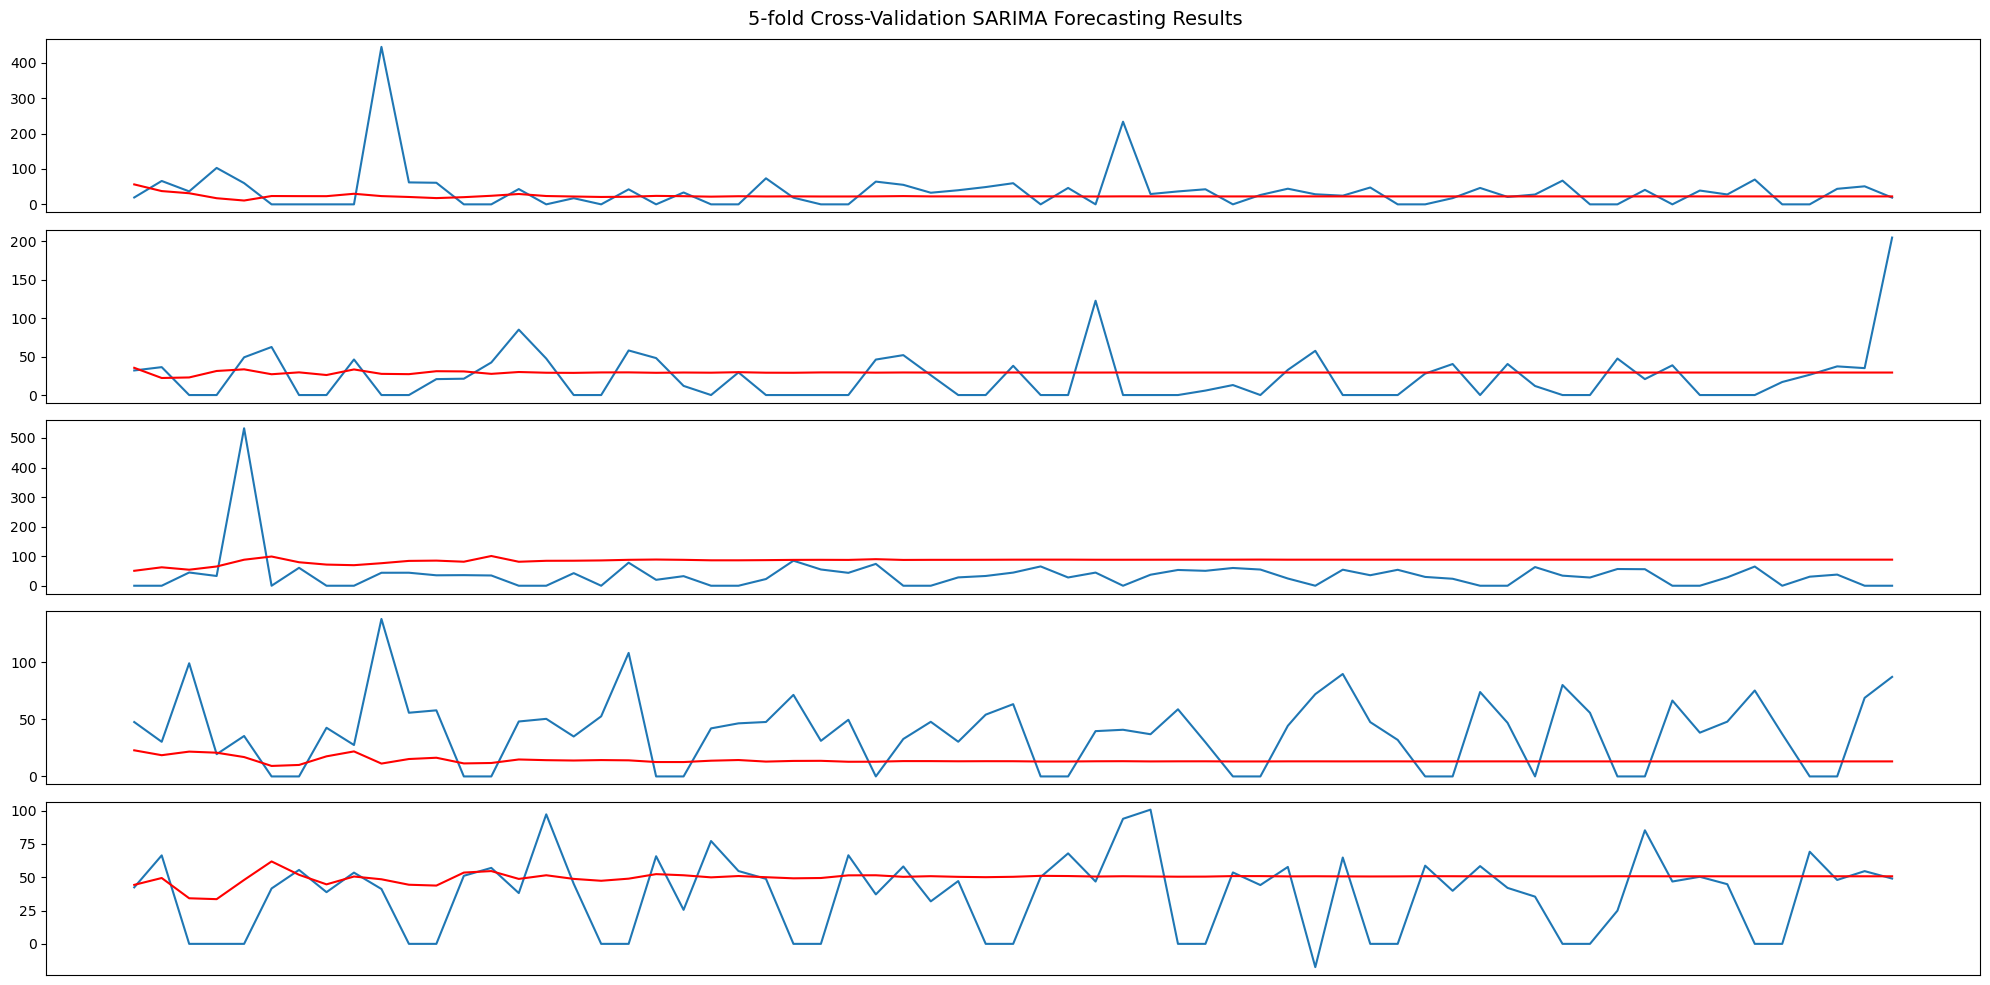

In [112]:
# Split data into training and testing

tscv = TimeSeriesSplit()
rmse_scores = []
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
ax_i = 0

# Perform cross-validation
for i_train, i_test in tscv.split(df):
    # Split training and testing data
    train, test = df.iloc[i_train], df.iloc[i_test]

    # Fit model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fitted = model.fit(disp=False)

    # Forecast for testing
    forecast = model_fitted.forecast(steps=len(test))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmse_scores.append(rmse)

    # Plot
    ax[ax_i].plot(test.index, test.values, label='Actual')
    ax[ax_i].plot(test.index, forecast, label='Forecast', color='red')
    ax[ax_i].axes.get_xaxis().set_visible(False)
    
    ax_i += 1

fig.suptitle('5-fold Cross-Validation SARIMA Forecasting Results', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'sarima_cv_forecast_results.png', bbox_inches='tight')
plt.show()


In [113]:
print(f"Average rmse score: {np.mean(rmse_scores):.2f}")

Average rmse score: 50.05


This score is not great at all. The SARIMA model appears to almost be predicting using the mean.

/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


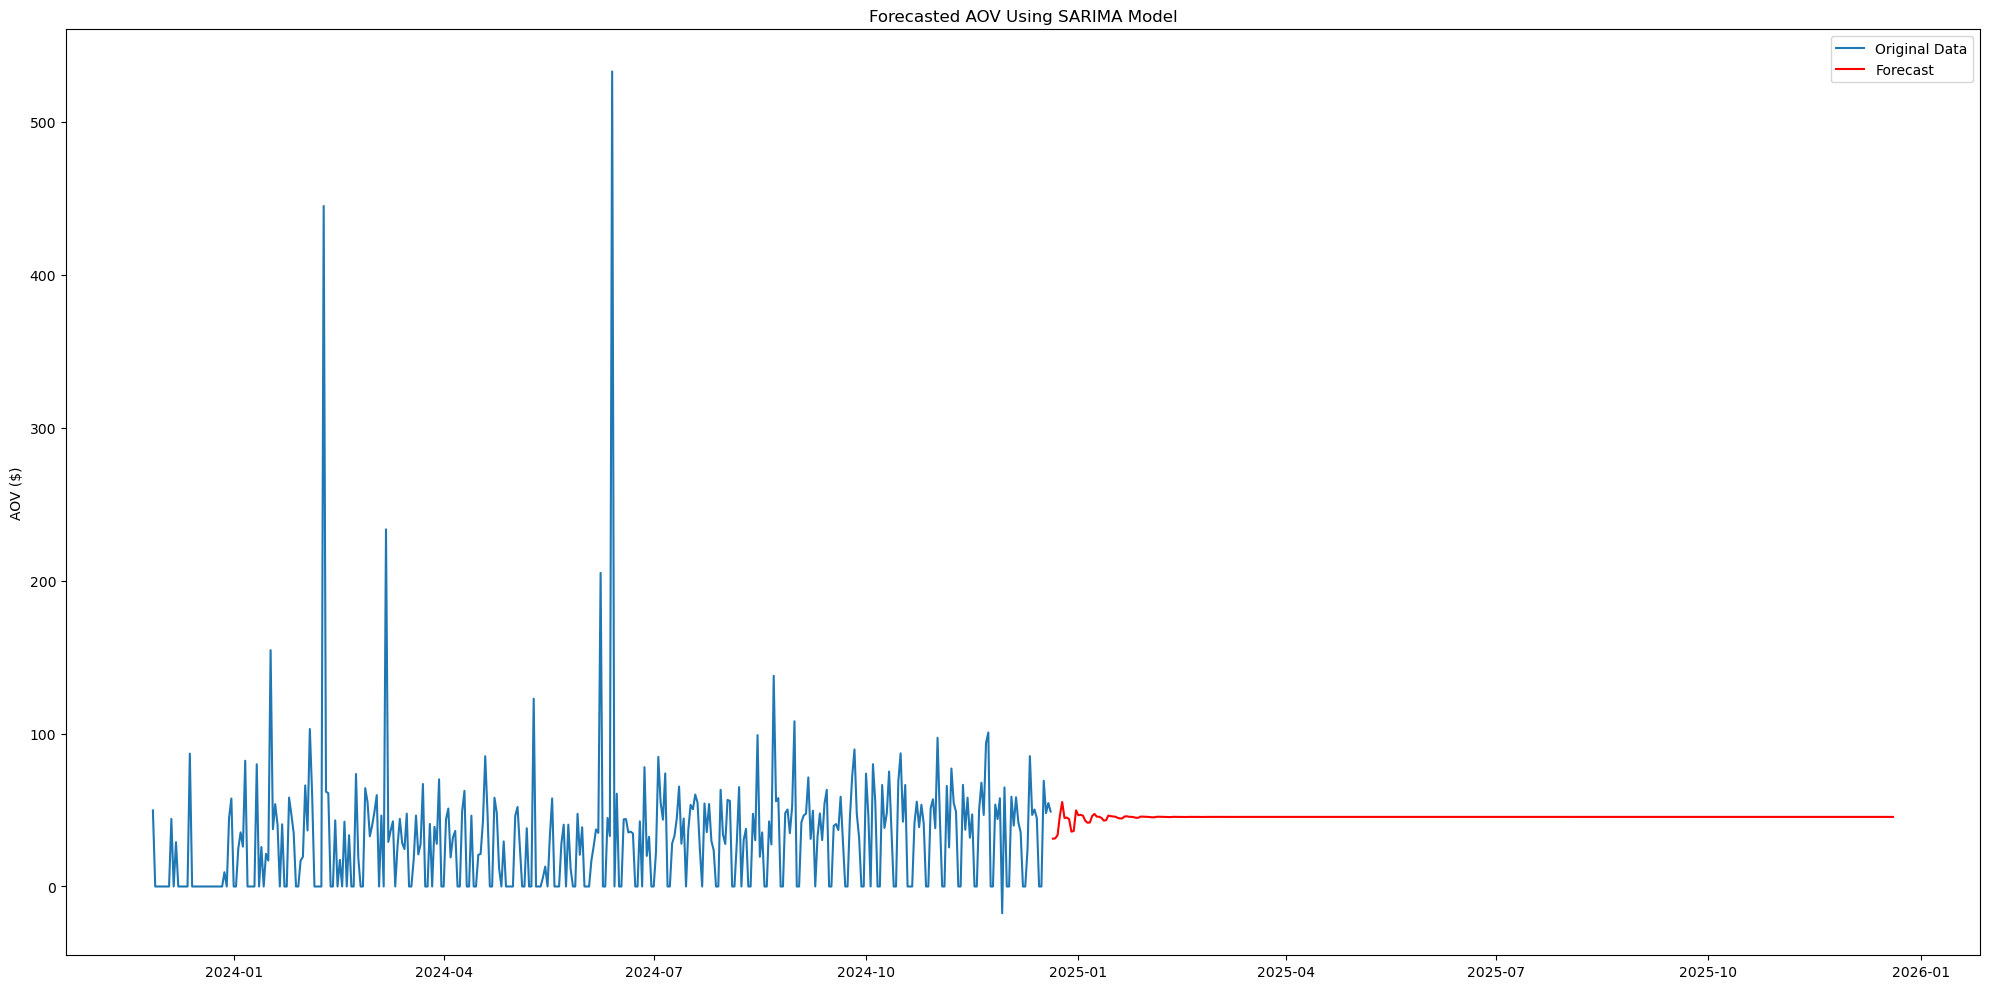

In [114]:
model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
model_fitted = model.fit(disp=False)

forecast = model_fitted.forecast(steps=365)

plt.figure(figsize=(20, 10))
plt.plot(df.index, df.values, label='Original Data')
plt.plot(forecast.index, forecast.values, color='red', label='Forecast')
plt.legend()
plt.ylabel('AOV ($)')
plt.title('Forecasted AOV Using SARIMA Model')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'sarima_year_forecast.png', bbox_inches='tight')
plt.show()

## Model Evaluation

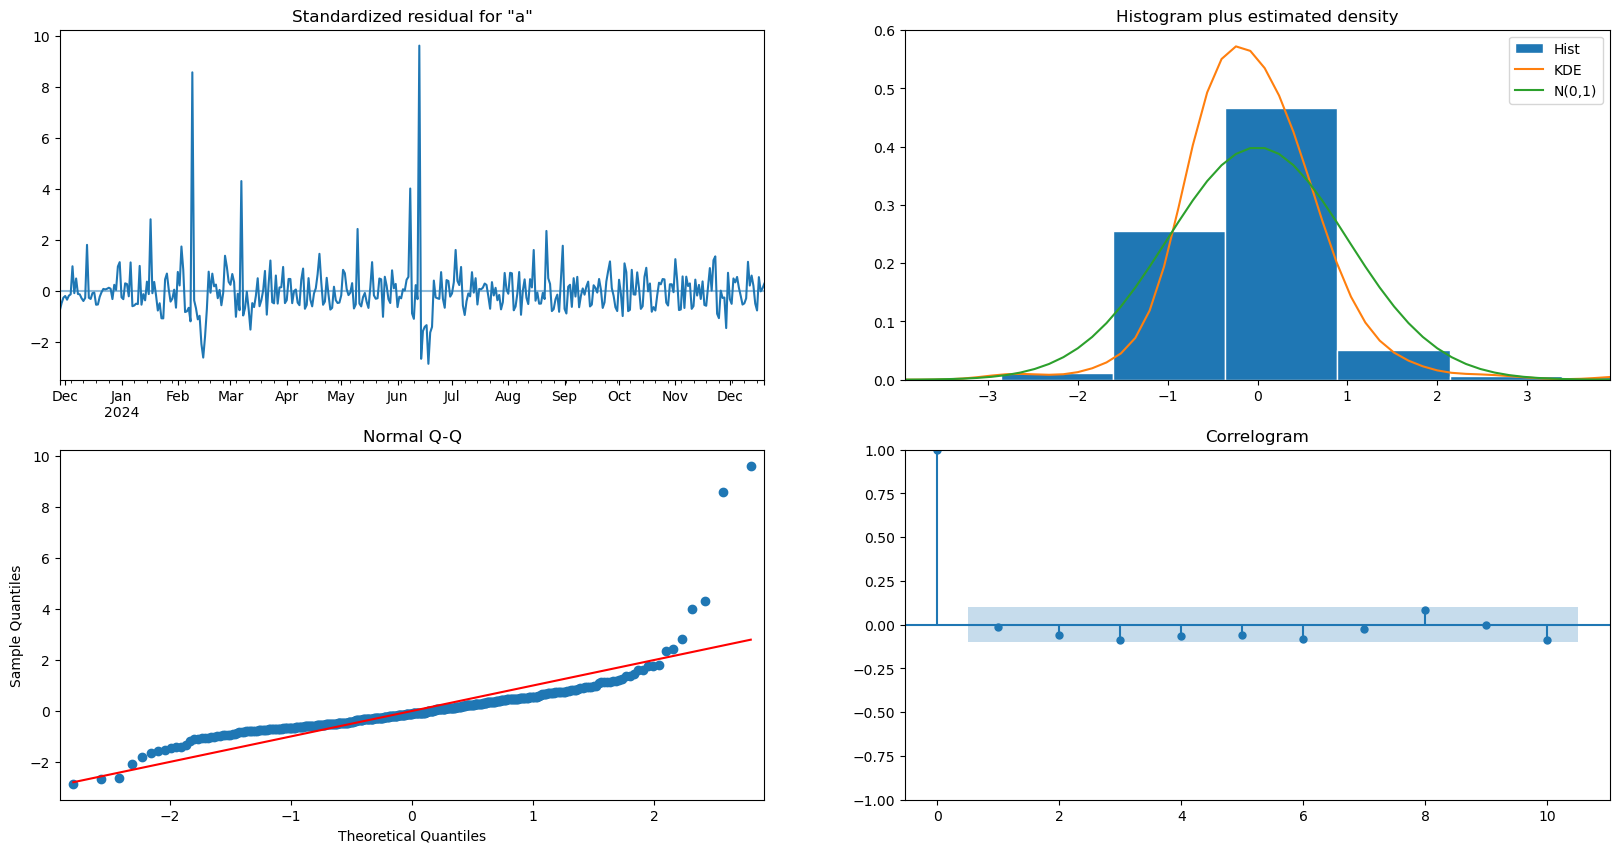

In [115]:
model_fitted.plot_diagnostics(figsize=(20,10))

plt.savefig(FIGURES_DIR / 'sarima_plot_diagnostics.png', bbox_inches='tight')
plt.show()

In [116]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               aov   No. Observations:                  390
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -2045.180
Date:                           Thu, 23 Jan 2025   AIC                           4106.361
Time:                                   23:55:23   BIC                           4138.069
Sample:                               11-27-2023   HQIC                          4118.931
                                    - 12-20-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8784      0.033    -26.279      0.000      -0.944      -0.813
ar.L2         -0.6857      0.051    -13.419      0.000      -0.786      -0.586
ar.L3         -0.5921      0.051    -11.709      0.000      -0.691      -0.493
ar.L4         -0.5115      0.037    -13.723      0.000      -0.585      -0.438
ar.L5         -0.2045      0.031     -6.642      0.000      -0.265      -0.144
ar.S.L7        0.1426      0.044      3.262      0.001       0.057       0.228
ar.S.L14       0.1819      0.079      2.293      0.022       0.026       0.337
sigma2      2147.8876     48.361     44.413      0.000    2053.101    2242.674
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             22050.31
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             4.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

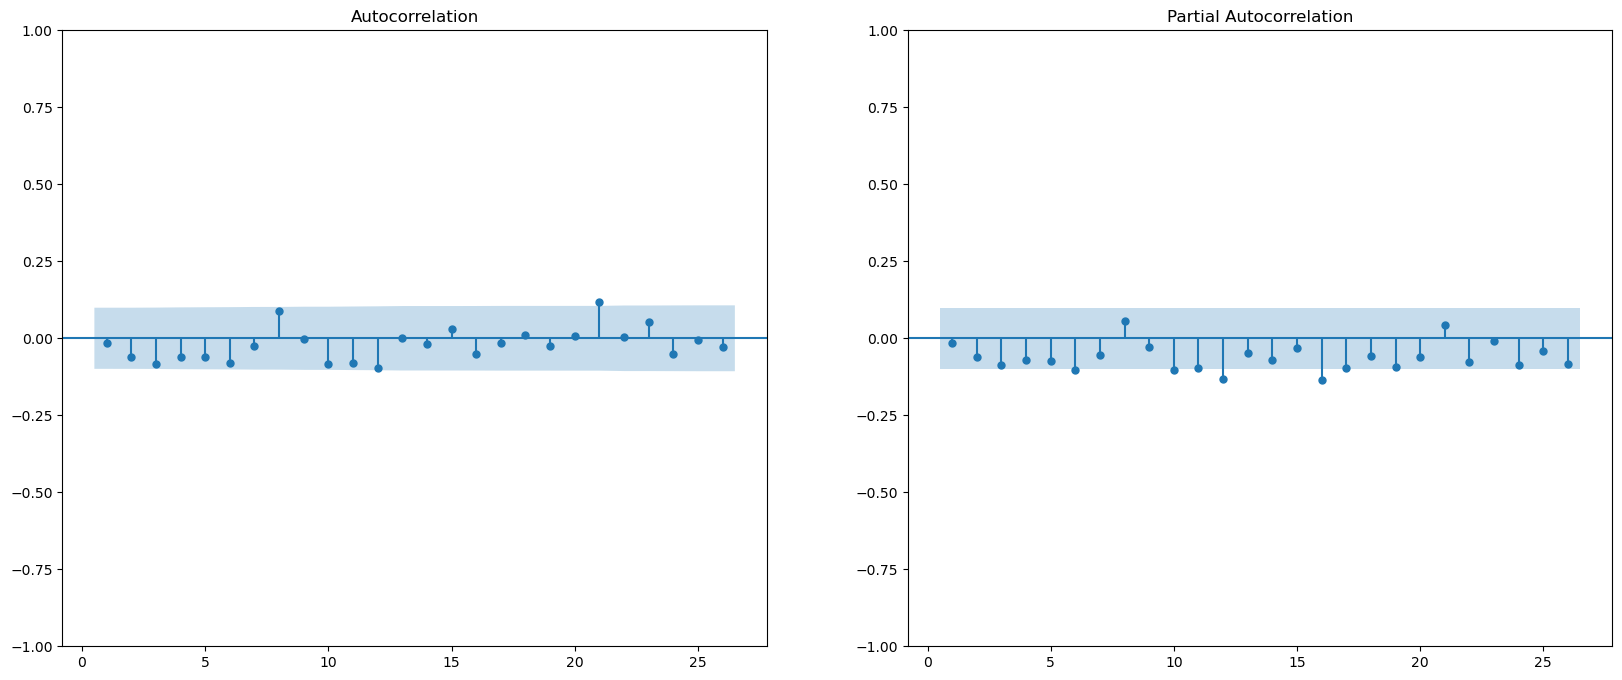

In [117]:
residuals = model_fitted.resid

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

plot_acf(residuals, ax=ax[0], zero=False)
plot_pacf(residuals, ax=ax[1], zero=False)

plt.savefig(FIGURES_DIR / 'sarima_acf_pacf.png', bbox_inches='tight')
plt.show()

This model does not appear to fit the data very well. This is probably because it did not capture the seasonality very well.

# Alternate Model

In [118]:
seasonal_order = (2, 1, 0, 7)

/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/arsen/anaconda3/envs/belly_rubb_analysis/l

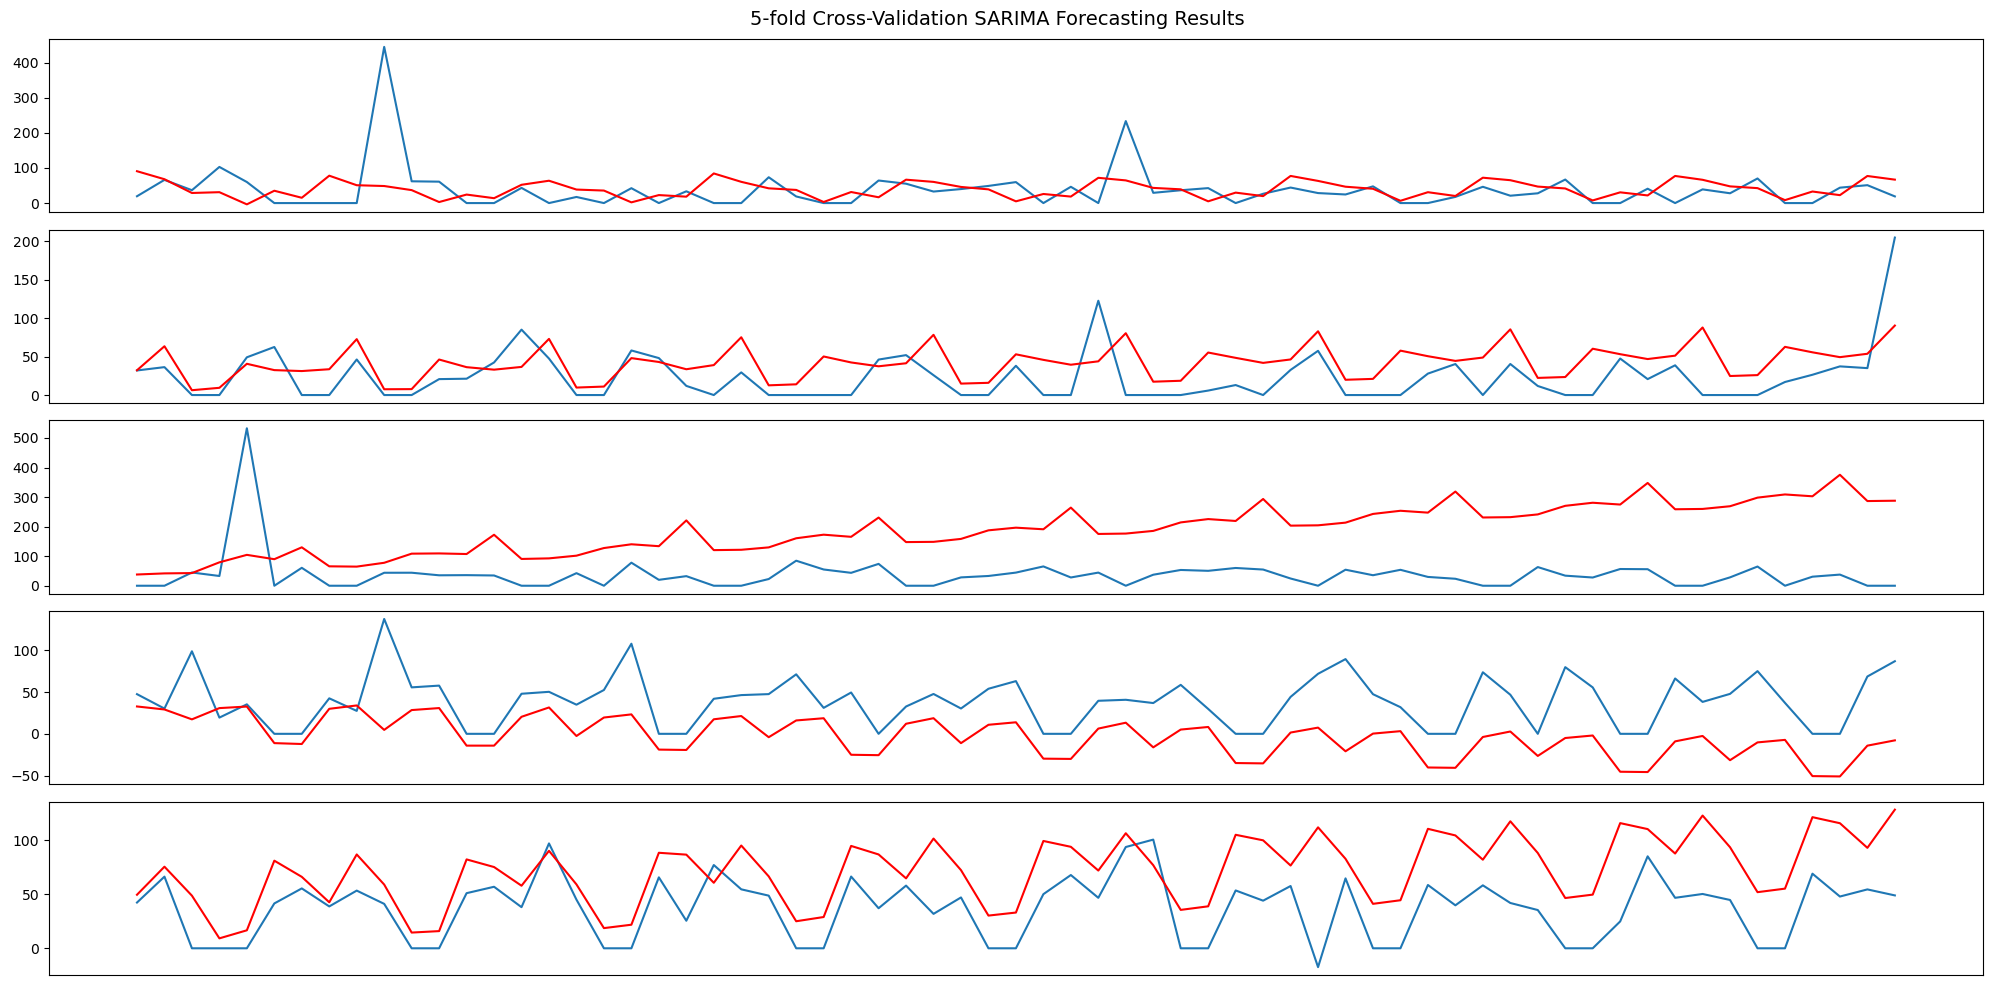

In [119]:
# Split data into training and testing

tscv = TimeSeriesSplit()
rmse_scores = []
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
ax_i = 0

# Perform cross-validation
for i_train, i_test in tscv.split(df):
    # Split training and testing data
    train, test = df.iloc[i_train], df.iloc[i_test]

    # Fit model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fitted = model.fit(disp=False)

    # Forecast for testing
    forecast = model_fitted.forecast(steps=len(test))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmse_scores.append(rmse)

    # Plot
    ax[ax_i].plot(test.index, test.values, label='Actual')
    ax[ax_i].plot(test.index, forecast, label='Forecast', color='red')
    ax[ax_i].axes.get_xaxis().set_visible(False)
    
    ax_i += 1

fig.suptitle('5-fold Cross-Validation SARIMA Forecasting Results', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'alternate_sarima_cv_forecast_results.png', bbox_inches='tight')
plt.show()


In [120]:
rmse_scores

[64.79704512195467,
 36.09338588728833,
 185.02889439299395,
 50.13846476096919,
 43.33816789665461]

## Conclusion

This model is worse. The conclusion from this information is that the AOV is very difficult to accurate forecast. This is due to the limited data available, both in terms of transaction quantities over time and net sales. An alternate predictive model will be considered to instead predict number of transactions or net sales.